# Week 5: 1D Advection

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

In [24]:
def construct_update_matrix(L, what_method, g):
    # Constructs an update matrix
    #-------------------------------------------------------------------------------
        
    if what_method == 'ftcs_advection':
        # Diagonal matrix to implement the centred spatial first-derivative
        D = np.zeros((L, L))
        
        # Fill diagonals
        for i in range(L-1):
            D[i, i+1] = 1     # Super-diagonal
            D[i+1, i] = -1    # Sub-diagonal 
        
        # Additional elements for periodic boundary conditions
        D[0, L-1] = -1        
        D[L-1, 0] = 1         
        
        # Update matrix
        M = np.eye(L) - 0.5*g*D
        
    elif what_method == 'lax_advection':
        
        # Diagonal matrix to implement the centred spatial first-derivative
        
        D = np.zeros((L, L))
        
        for i in range(L-1):
            D[i, i+1] = 1     # Super-diagonal
            D[i+1, i] = -1    # Sub-diagonal
            
        # Additional elements for periodic boundary conditions
        D[0, L-1] = -1        
        D[L-1, 0] = 1         
        
        # Lax averaging matrix
        A = 0.5*np.abs(D)
        
        # Update matrix
        M = A - 0.5*g*D
        
    else:
        
        raise ValueError(f"Unknown method: '{what_method}'")
    
    return M

In [25]:
def advection(what_method, tau):
    # Solve the advection equation with periodic BCs
        
    if what_method == 'ftcs':
        
        print('Using the ftcs method!')
        
    else:
        
        print('Using the Lax method!')
        
    # --- Set parameters: --- #
    
    # Propagation speed:
    c = 1
    
    # Spatial step:
    h = 0.01
    
    
    #--------------------------------------------------------------------------
    #  Initialization
    #--------------------------------------------------------------------------

    
    # Number of steps such that the pulse should propagate through
    # the periodic domain once
    numSteps = int(np.ceil((1+h)/(c*tau)))
    
    # Vector of x values
    x = np.arange(0, 1 + h, h)
    L = len(x)
    
    #-------------------------------------------------------------------------------
    #  Construct the update matrix, M
    #-------------------------------------------------------------------------------
    g = c * tau / h
    
    if what_method == 'ftcs':
        
        M = construct_update_matrix(L, 'ftcs_advection', g)
        
    elif what_method == 'lax':
        
        M = construct_update_matrix(L, 'lax_advection', g)
        
    else:
        raise ValueError(f"Unknown method '{what_method}'")
    
    # Calculate the spectral radius of M
    eigenvalues = np.linalg.eigvals(M)
    rho = max(abs(eigenvalues))
    
    print(f"Spectral radius: {rho:.4f}")
    
    #-------------------------------------------------------------------------------
    #  Set Initial conditions (a Gaussian pulse at x = 0.5)
    #-------------------------------------------------------------------------------
   
    sig = 0.1
    amp = np.exp(-0.5 * (x - 0.5)**2 / sig**2)
    amp0 = amp.copy()  # store initial profile
    
    # Record a(x,t) matrix for visualisation
    amp_xt = np.zeros((L, numSteps + 1))
    amp_xt[:, 0] = amp0
    
    # Precompute discretization of time:
    time = np.arange(numSteps + 1) * tau
    
    # Initialize array for analytical solution
    analytic_xt = np.zeros((L, numSteps + 1))
    analytic_xt[:, 0] = amp0  # Initial condition
    
    #-------------------------------------------------------------------------------
    # March forwards in time:
    #-------------------------------------------------------------------------------
    
    for n in range(numSteps):
        
        # Update the wave amplitude profile:
        amp = M @ amp
        
        # Calculate the profile for the exact analytic solution
        k = int(np.floor(c * time[n+1] / h))  # The index the peak has reached
        xp = np.concatenate((x[k:], x[:k]))  # Shift x to left by k steps
        
        analytic_xt[:, n+1] = np.roll(amp0, k)
        
        # Record a(x,t) matrix for visualisation
        amp_xt[:, n+1] = amp
    
    
    return numSteps, xp, analytic_xt, amp0, amp_xt, time

Using the ftcs method!
Spectral radius: 1.4141


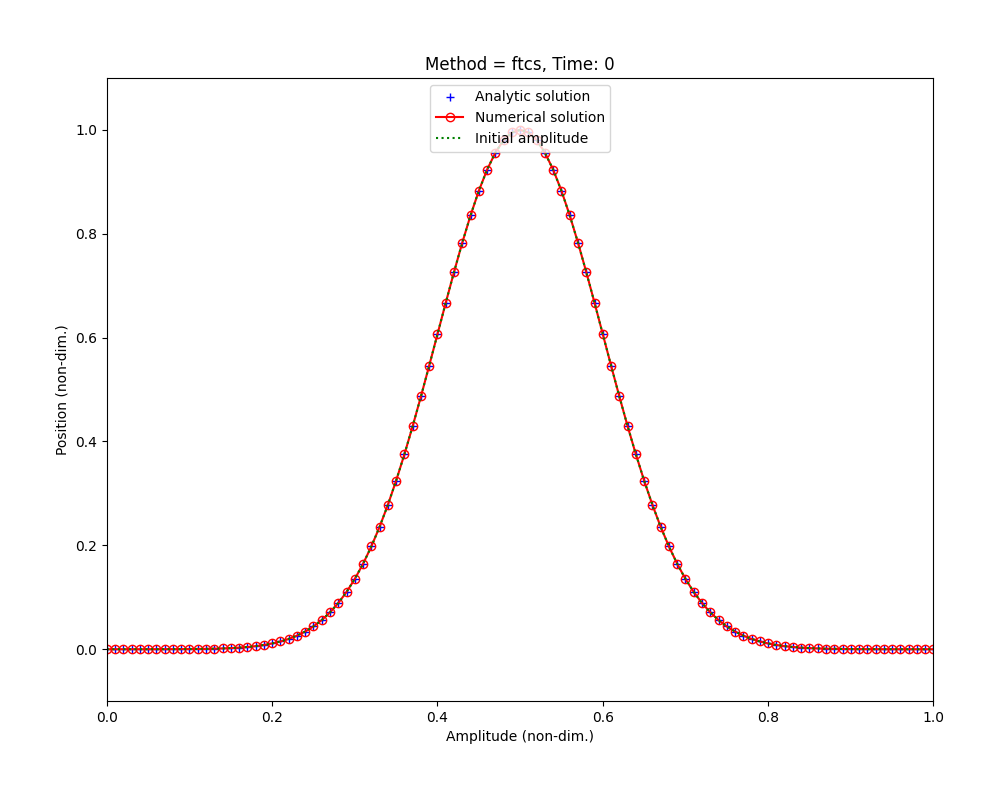

In [26]:
## -------------------------------- Method: ftcs -------------------------------- ##
    
numSteps_ftcs, xp_ftcs, analytic_xt_ftcs, amp0_ftcs, amp_xt_ftcs, time_ftcs = advection('ftcs', 0.01)

#-------------------------------------------------------------------------------
# Plot the results as an animation

%matplotlib widget 
# This enables interactive mode; uncomment and run the following line to go back to static:
# %matplotlib inline
    
# Set up figure
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel('Amplitude (non-dim.)')
ax.set_ylabel('Position (non-dim.)')


# Create initial plots that will be updated
plot1, = ax.plot(xp_ftcs, analytic_xt_ftcs[:, 0], '+', color='blue', markeredgecolor='blue', label='Analytic solution')
plot2, = ax.plot(xp_ftcs, amp_xt_ftcs[:, 0], '-o', color='red', markerfacecolor='none',\
                markeredgecolor='red', linewidth=1.5, label='Numerical solution')
ax.plot(xp_ftcs, amp0_ftcs, ':', color='green', linewidth=1.5, label='Initial amplitude')


# Set initial axis limits
ax.set_xlim(0, 1)
y_min = min(np.min(analytic_xt_ftcs[:, 0]), np.min(amp_xt_ftcs[:, 0]))
y_max = max(np.max(analytic_xt_ftcs[:, 0]), np.max(amp_xt_ftcs[:, 0]))
padding = (y_max - y_min) * 0.1
ax.set_ylim(y_min - padding, y_max + padding)

# Title for showing time info
title = ax.set_title(f'Method = ftcs, Time: 0')


# Update function for animation
def update(frame):
    
    # Update plot data
    plot1.set_ydata(analytic_xt_ftcs[:, frame])
    plot2.set_ydata(amp_xt_ftcs[:, frame])
    
    # Update title
    title.set_text(f'Method = ftcs, Time: {frame*time_ftcs[1]:.2g}')
    
    # Get current extremes in this frame
    current_min = min(np.min(analytic_xt_ftcs[:, frame]), np.min(amp_xt_ftcs[:, frame]))
    current_max = max(np.max(analytic_xt_ftcs[:, frame]), np.max(amp_xt_ftcs[:, frame]))
    
    # Get current axis limits
    y_min, y_max = ax.get_ylim()
    
    # Expand limits for zoom out effect
    new_min = min(y_min, current_min)
    new_max = max(y_max, current_max)
    
    # Add padding proportional to the range
    padding = (new_max - new_min) * 0.01
    
    # Set the new limits
    ax.set_ylim(new_min - padding, new_max + padding)
    
    return plot1, plot2, title

# Create animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=range(numSteps_ftcs+1), 
                             interval=50, blit=False, repeat=False)

# Add legend and layout
ax.legend(loc='upper center')
plt.tight_layout(pad=4)

# Display the animation
plt.show();

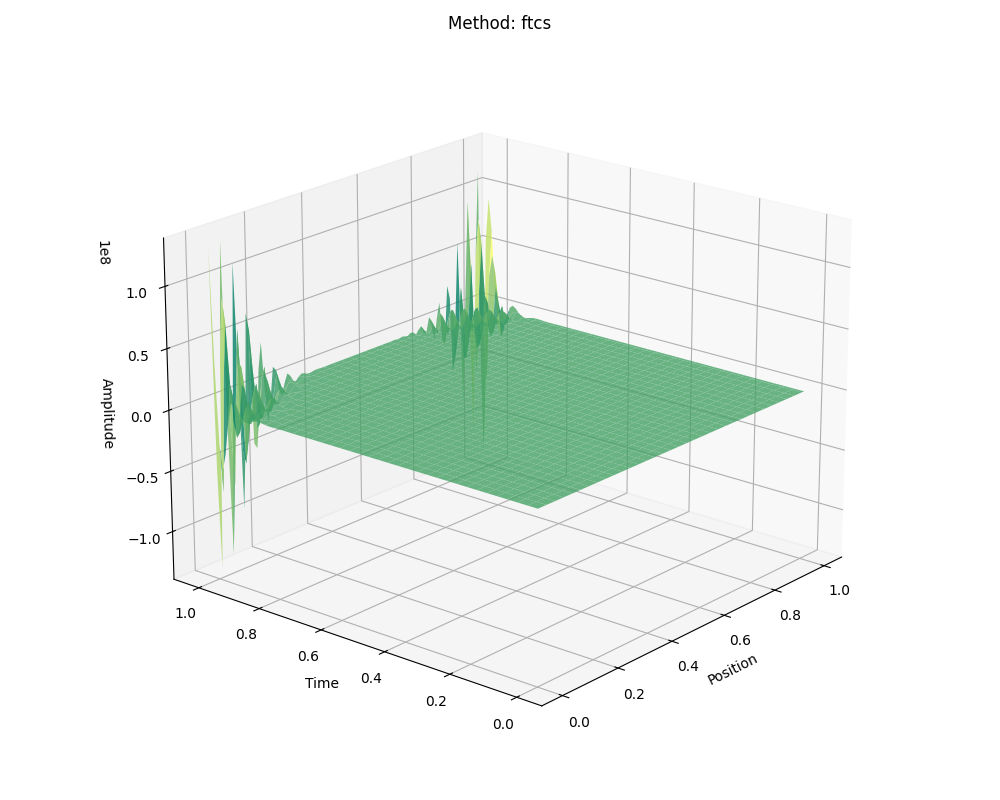

In [27]:
#-------------------------------------------------------------------------------
# Visualization of temperature versus position and time as a 3d surface plot

# Create figure for the 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot
surf = ax.plot_surface(
    *np.meshgrid(xp_ftcs, time_ftcs),  
    amp_xt_ftcs.T,                
    cmap='summer',          
    edgecolor='none',        
    alpha=0.8                
)

# Set labels
ax.set_xlabel('Position')
ax.set_ylabel('Time')
ax.set_zlabel('Amplitude')

ax.set_title('Method: ftcs')

# Initial viewing angle
ax.view_init(elev=20, azim=220)

plt.tight_layout()
plt.show()

Using the Lax method!
Spectral radius: 1.0000


/tmp/ipykernel_367598/3348117786.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


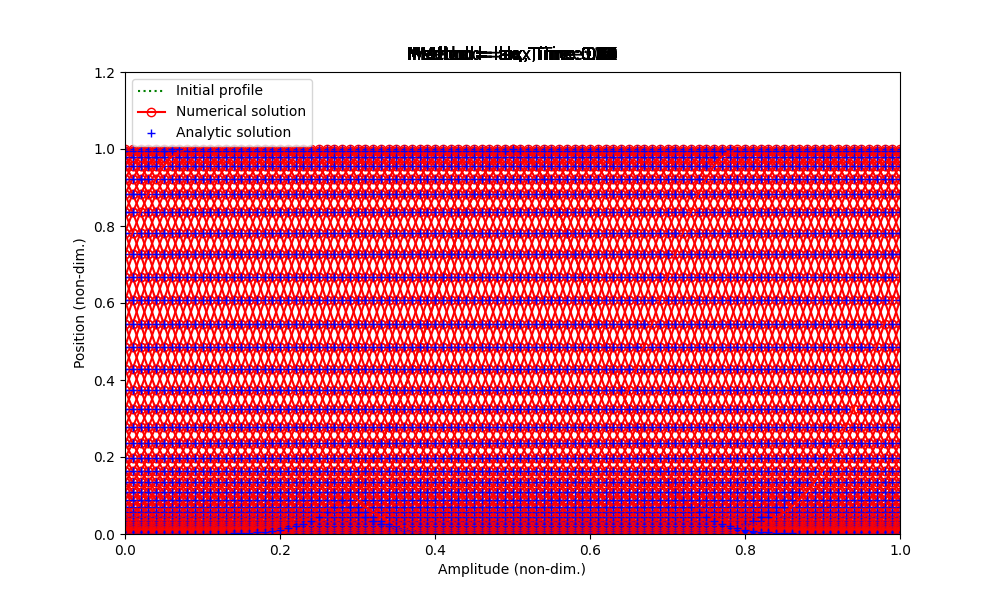

In [28]:
## -------------------------------- Method: Lax -------------------------------- ##
numSteps_lax, xp_lax, analytic_xt_lax, amp0_lax, amp_xt_lax, time_lax = advection('lax', 0.01)
#-------------------------------------------------------------------------------
# Plot the results as an animation
%matplotlib widget 
# This enables interactive mode; uncomment and run the following line to go back to static:
# %matplotlib inline
    
# Set up figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Amplitude (non-dim.)')
ax.set_ylabel('Position (non-dim.)')
ax.set_xlim(0,1)
ax.set_ylim(0,1.2)
# Plot initial profile
ax.plot(xp_lax, amp0_lax, ':', color='g', linewidth=1.5, label='Initial profile')
# Plot the numerical solutions interactively
artists = []
for i in range(numSteps_lax+1):
    
    label1 = 'Numerical solution' if i == numSteps_lax - 1 else None
    label2 = 'Analytic solution' if i == numSteps_lax - 1 else None
        
    plot1, = ax.plot(xp_lax, amp_xt_lax[:, i],  '-o', color='red', markerfacecolor='none',\
                     markeredgecolor='red', linewidth=1.5, label=label1)
    plot2, = ax.plot(xp_lax, analytic_xt_lax[:, i], '+', color='blue', markeredgecolor='blue', label=label2)
    title = ax.text(0.5, 1.23, f'Method = lax, Time: {i*time_lax[1]:.2g}',\
                    size=12, horizontalalignment='center')    
        
    artists.append([plot1, plot2, title])
    
ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=50, repeat=False, blit=True)
ax.legend(loc='upper left');

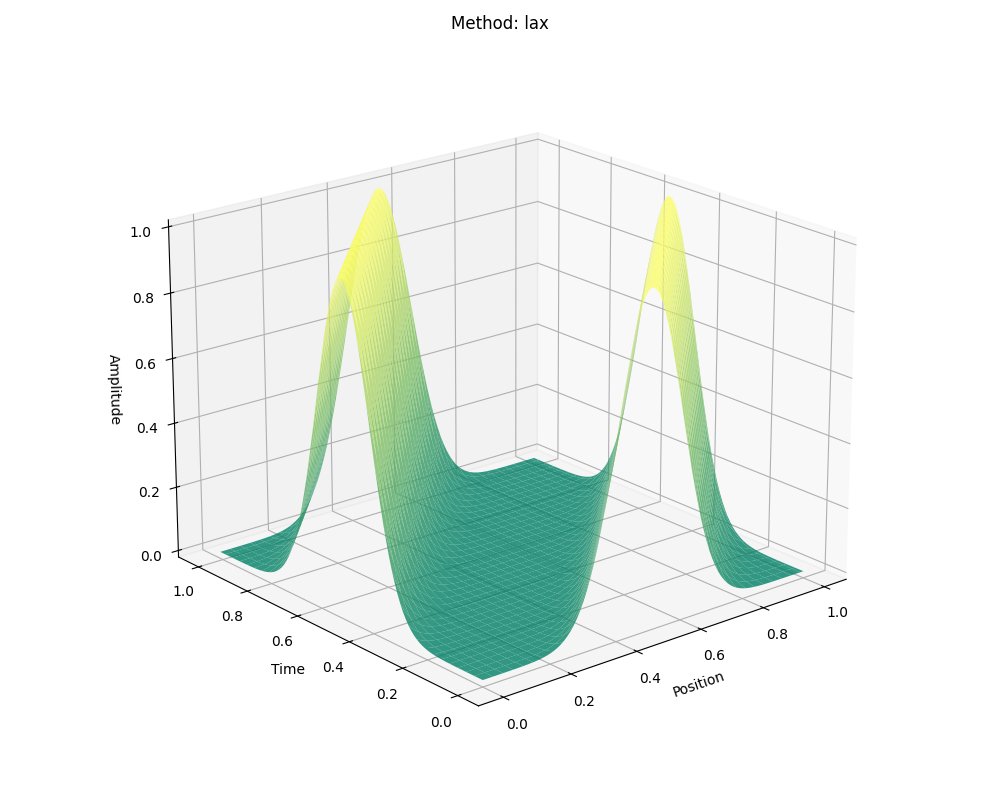

In [29]:
#-------------------------------------------------------------------------------
# Visualization of temperature versus position and time as a 3d surface plot

# Create figure for the 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot
surf = ax.plot_surface(
    *np.meshgrid(xp_lax, time_lax),  
    amp_xt_lax.T,                
    cmap='summer',          
    edgecolor='none',        
    alpha=0.8                
)

# Set labels
ax.set_xlabel('Position')
ax.set_ylabel('Time')
ax.set_zlabel('Amplitude')

ax.set_title('Method: lax')

# Initial viewing angle
ax.view_init(elev=20, azim=230)

plt.tight_layout()
plt.show()